# Assignment 1

<b>Group 82</b>
* <b> Student 1 </b> : Joris Willems, 0908753
* <b> Student 2 </b> : Lars Schilders, 0908729

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.



# Question 1 - Keras implementation (10 pt)

### Word embeddings
Build word embeddings with a Keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training. Use a window size of 2 to train the embeddings (`window_size` in the jupyter notebook). 

1. Build word embeddings of length 50, 150 and 300 using the Skipgram model
2. Build word embeddings of length 50, 150 and 300 using CBOW model
3. Analyze the different word embeddings:
    - Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in the paper. Do not use existing libraries for this task such as Gensim. 
Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. $e_{x}$ denotes the embedding of word $x$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.
    - Give at least 5 different  examples of analogies.
    - Compare the performance on the analogy tasks between the word embeddings and briefly discuss your results.

4. Discuss:
  - Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


<b>HINT</b> See practical 3.1 for some helpful code to start this assignment.


### Import libraries

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [36]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence

# other helpful libraries
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab as plt
import pandas as pd

In [37]:
def save_history(path, history):
    import json, os
    with open(path, 'w') as f:
        json.dump(history.history, f)
        
def save_embedding(path, model):
    np.save(path, model.get_weights()[0])
    
def plot_history(history, title):
    pd.DataFrame(history.history).plot()
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("Cross-Entropy")
    plt.show()
    

In [3]:
print(tf.__version__) #  check what version of TF is imported

2.1.0


### Import file

If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/2IMM10 - Deep Learning/'

In [4]:
file_name = 'alice.txt'
corpus = open(file_name).readlines()

### Data preprocessing

See Practical 3.1 for an explanation of the preprocessing steps done below.

In [5]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus

In [6]:
print("Number of words in corpus: {} \nNumber of words in vocabulary: {}".format(n_samples, V))

Number of words in corpus: 27165 
Number of words in vocabulary: 2557


In [7]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [8]:
# parameters
window_size = 2
window_size_corpus = 4

## Task 1.1 - Skipgram
Build word embeddings of length 50, 150 and 300 using the Skipgram model.

In [41]:
#prepare data for skipgram
def generate_data_skipgram(corpus, window_size, V):

    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add the input word
                    #in_words.append(word)
                    all_in.append(word)
                    # Add one-hot of the context words
                    all_out.append(to_categorical(words[i], V))
                                      
    return (np.array(all_in),np.array(all_out))

In [42]:
# create training data
x , y = generate_data_skipgram(corpus,window_size,V)

Train on 94556 samples
Epoch 1/2
94556/94556 [==============================] - 3s 35us/sample - loss: 5.0282
Epoch 2/2
94556/94556 [==============================] - 3s 35us/sample - loss: 4.9917


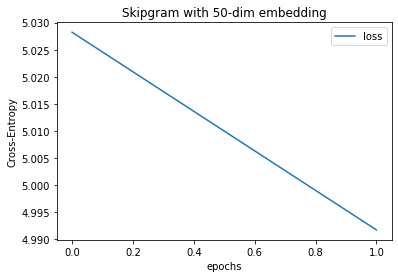

In [40]:
# create skipgram architecture
def build_skipgram(dim):
    skipgram = Sequential()
    skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
    skipgram.add(Reshape((dim, )))
    skipgram.add(Dense(V, kernel_initializer='glorot_uniform', activation='softmax'))
    skipgram.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1))
    return skipgram

def fit_skipgram(dim, batch_size=64, epochs=20):
    skipgram = build_skipgram(dim)
    history = skipgram_50.fit(x, y, batch_size=batch_size, epochs=epochs)
    save_embedding("embeddingSkipgram/{}.npy".format(dim), skipgram)
    save_history("embeddingSkipgram/{}.json".format(dim), history)
    plot_history(history, title="Skipgram with {}-dim embedding".format(dim))
  
fit_skipgram(50, batch_size=64, epochs=15)
fit_skipgram(100, batch_size=64, epochs=15)
fit_skipgram(150, batch_size=64, epochs=15)

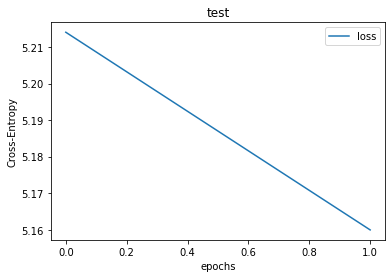

In [38]:
plot_history(history, title='test')

In [15]:
skipgram_50 = build_skipgram(50)
hist_SG_50 = skipgram_50.fit(x, y, batch_size=bs, epochs=2)

Train on 94556 samples
Epoch 1/2
94556/94556 [==============================] - 4s 38us/sample - loss: 6.1116
Epoch 2/2
94556/94556 [==============================] - 3s 36us/sample - loss: 5.7631


In [22]:
with open("test.json", 'w') as f:
    json.dump(hist_SG_50.history, f)



{'loss': [6.111622221049603, 5.7630591651520815]}

<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [12]:
# train skipgram model
epochs = 30
bs = 64

skipgram_50 = build_skipgram(50)
hist_SG_50 = skipgram_50.fit(x, y, batch_size=bs, epochs=epochs)
skipgram_150 = build_skipgram(150)
hist_SG_150 = skipgram_150.fit(x, y, batch_size=bs, epochs=epochs)
skipgram_300 = build_skipgram(300)
hist_SGF_300 = skipgram_300.fit(x, y, batch_size=bs, epochs=epochs)

Train on 94556 samples
Epoch 1/30
44224/94556 [=============>................] - ETA: 2s - loss: 6.3257

KeyboardInterrupt: 

In [48]:
# save embeddings for vectors of length 50, 150 and 300 using skipgram model

np.save("embeddingSkipgram/embedding50.npy", skipgram_50.get_weights()[0])
np.save("embeddingSkipgram/embedding150.npy", skipgram_150.get_weights()[0])
np.save("embeddingSkipgram/embedding300.npy", skipgram_300.get_weights()[0])

## Task 1.2 - CBOW

Build word embeddings of length 50, 150 and 300 using CBOW model.

In [17]:
# prepare data for CBOW
def generate_data_cbow(corpus, window_size, V):
    
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            
            context = [words[i] for i in range(p, n) if ((i != index) and (0 <= i < L))]
            context = (maxlen - len(context)) * [0] + context
            
            all_in.append(context)

            all_out.append(to_categorical(word, V))
                                      
    return (np.array(all_in),np.array(all_out))

# create training data
x_cbow, y_cbow = generate_data_cbow(corpus,window_size, V)

In [18]:
# create CBOW architecture
def build_cbow(dim):
    cbow = Sequential()
    cbow.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=window_size*2))
    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
    cbow.add(Dense(V, kernel_initializer='glorot_uniform', activation='softmax'))
    cbow.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=2))
    return cbow

In [19]:
# train CBOW model
epochs = 50
bs = 64

cbow_50 = build_cbow(50)
hist_cbow_50 = cbow_50.fit(x_cbow, y_cbow, batch_size=bs, epochs=epochs)
cbow_150 = build_cbow(150)
hist_cbow_150 = cbow_150.fit(x_cbow, y_cbow, batch_size=bs, epochs=epochs)
cbow_300 = build_cbow(300)
hist_cbow_300 = cbow_300.fit(x_cbow, y_cbow, batch_size=bs, epochs=epochs)

Train on 27165 samples
Epoch 1/50
27165/27165 [==============================] - 1s 46us/sample - loss: 7.64060s - loss: 7.
Epoch 2/50
27165/27165 [==============================] - 1s 38us/sample - loss: 7.2614
Epoch 3/50
27165/27165 [==============================] - 1s 38us/sample - loss: 6.98900s - loss: 
Epoch 4/50
27165/27165 [==============================] - 1s 38us/sample - loss: 6.8040
Epoch 5/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.6721
Epoch 6/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.5789
Epoch 7/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.5095
Epoch 8/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.4545
Epoch 9/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.40810s - lo
Epoch 10/50
27165/27165 [==============================] - 1s 39us/sample - loss: 6.36700
Epoch 11/50
27165/27165 [==============================] - 1s 40

In [21]:
# save embeddings for vectors of length 50, 150 and 300 using CBOW model
np.save("embeddingCBOW/embedding50.npy", cbow_50.get_weights()[0])
np.save("embeddingCBOW/embedding150.npy", cbow_150.get_weights()[0])
np.save("embeddingCBOW/embedding300.npy", cbow_300.get_weights()[0])

## Task 1.3 - Analogy function

Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for both CBOW and Skipgram model. This means that for each analogy we have 6 outputs. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`) and a boolean answer whether the predicted word **exactly** equals the true word. 

<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted word (sim2) | Embedding | Correct?|
|------|------|------|------|------|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | SG_50 | True / False|

* Give at least 5 different  examples of analogies.
* Compare the performance on the analogy s between the word embeddings and briefly discuss your results.

In [50]:
skipgram_embedding_50 = np.load('embeddingSkipgram/embedding50.npy')
skipgram_embedding_150 = np.load('embeddingSkipgram/embedding150.npy')
skipgram_embedding_300 = np.load('embeddingSkipgram/embedding300.npy')

cbow_embedding_50 = np.load('embeddingCBOW/embedding50.npy')
cbow_embedding_150 = np.load('embeddingCBOW/embedding150.npy')
cbow_embedding_300 = np.load('embeddingCBOW/embedding300.npy')

In [78]:
emb_dict = {'SG_50': skipgram_embedding_50, 'SG_150': skipgram_embedding_150, 'SG_300': skipgram_embedding_300,
           'CBOW_50': cbow_embedding_50, 'CBOW_150': cbow_embedding_150, 'CBOW_300': cbow_embedding_300}

In [17]:
def embed(word, embedding, vocab_size = V, tokenizer=tokenizer):
    # get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def findAnalogy(prediction, embedding):
    
    all_word_embeddings = embed(list(tokenizer.word_index.keys()), embedding)
    
    similarity = cosine_similarity(all_word_embeddings, prediction)

    word_idx = similarity.argsort(axis=0)[-2,0]

    return list(tokenizer.word_index.keys())[word_idx]



In [63]:
def analogyOutput(emb_name, relation_1, relation_2):
    
    emb = emb_dict[emb_name]
    
    analogy_task = "{} is to {} as {} is to ?".format(relation_1[0], relation_1[1], relation_2[0], relation_2[1])
    
    prediction = embed(relation_1[0], emb) - embed(relation_1[1], emb) + embed(relation_2[0], emb)
    
    predicted_word = findAnalogy(prediction, emb)
    sim2 = cosine_similarity(prediction, embed(predicted_word, emb))[0,0]
    
    true_word = relation_2[1]
    sim1 = cosine_similarity(prediction, embed(true_word, emb))[0,0]
    
    correct = true_word == predicted_word
    
    return [analogy_task, true_word, sim1, predicted_word, sim2, emb_name, correct]

## Semantic

In [102]:
df = pd.DataFrame(columns = ['Analogy task', 'True word', 'sim1', 'Predicted word' ,'sim2', 'Embedding', 'Correct?'])

firstRelations = [["up", "down"], ["everything","nothing"], ["king", "man"]]
secondRelations = [["high", "low"], ["always", "never"], ["queen", "woman"]]

for rel_1, rel_2 in zip(firstRelations, secondRelations):
    
    for emb_name in emb_dict:

        output = analogyOutput(emb_name, rel_1, rel_2)
        df = df.append(pd.Series(output, index=df.columns), ignore_index=True)
df

,Analogy task,True word,sim1,Predicted word,sim2,Embedding,Correct?
0,up is to down as high is to ?,low,0.142158,sleepy,0.497267,SG_50,False
1,up is to down as high is to ?,low,-0.080373,up,0.459103,SG_150,False
2,up is to down as high is to ?,low,-0.039956,up,0.480250,SG_300,False
3,up is to down as high is to ?,low,0.065749,behind,0.500375,CBOW_50,False
4,up is to down as high is to ?,low,0.012946,high,0.448162,CBOW_150,False
5,up is to down as high is to ?,low,-0.002117,high,0.423648,CBOW_300,False
6,everything is to nothing as always is to ?,never,-0.238600,from,0.533501,SG_50,False
7,everything is to nothing as always is to ?,never,-0.015764,everything,0.544888,SG_150,False
8,everything is to nothing as always is to ?,never,-0.040131,everything,0.564488,SG_300,False
9,everything is to nothing as always is to ?,never,0.157352,everything,0.489072,CBOW_50,False


## Syntactic

In [101]:
df = pd.DataFrame(columns = ['Analogy task', 'True word', 'sim1', 'Predicted word' ,'sim2', 'Embedding', 'Correct?'])

firstRelations = [["he", "him"], ["eye", "eyes"], ["go", "went"],  ["know", "knew"]]
secondRelations = [["she", "her"], ["word", "words"], ["do", "did"], ["is", "was"]]

for rel_1, rel_2 in zip(firstRelations, secondRelations):
    
    for emb_name in emb_dict:

        output = analogyOutput(emb_name, rel_1, rel_2)
        df = df.append(pd.Series(output, index=df.columns), ignore_index=True)
df

,Analogy task,True word,sim1,Predicted word,sim2,Embedding,Correct?
0,he is to him as she is to ?,her,0.260575,he,0.768761,SG_50,False
1,he is to him as she is to ?,her,-0.024845,she,0.554767,SG_150,False
2,he is to him as she is to ?,her,-0.028425,she,0.573049,SG_300,False
3,he is to him as she is to ?,her,-0.115868,he,0.662769,CBOW_50,False
4,he is to him as she is to ?,her,-0.081710,he,0.668650,CBOW_150,False
5,he is to him as she is to ?,her,-0.081410,she,0.669001,CBOW_300,False
6,eye is to eyes as word is to ?,words,-0.042818,mabel,0.729473,SG_50,False
7,eye is to eyes as word is to ?,words,0.010355,eye,0.560499,SG_150,False
8,eye is to eyes as word is to ?,words,0.057661,eye,0.600743,SG_300,False
9,eye is to eyes as word is to ?,words,0.122762,word,0.561993,CBOW_50,False


## Task 1.4 - Discussion
Answer the following question:
* Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


##### ANSWER:

The skipgram model arranges the data in such a way that a certain word gets matched with its context words. More specifically, every word gets paired up with all the words in its defined context (*window_size* words in front of the word and *window_size* words behind the word), such that the training samples consist of word pairs, i.e. [(word, context_word1), (word, context_word2), (word, context_word3), (word, context_word4)] for a window_size of 2. 

On the contrary, the CBOW model matches the whole context of a word to that word itself. The embedding of all the words in the context gets averaged to obtain one embedding of the complete context. The training sample for one word takes the form ([context_word1, context_word2, context_word3, context_word4], word). 

Note that one single word in the corpus results in the generation of 2 * *window_size* training samples for the Skipgram model, whereas for the CBOW model one single word results in the generation of only 1 training sample. 

# Question 2 - Peer review (0 pt):
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member
contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others? You can use the table below to make an overview of how the tasks were divided:



| Student name | Task  |
|------|------|
|  student name 1  | task x |
| student name 2  | task x|
| everyone | task x|
